# Convergence plot

This notebook generates the plot that shows the speed of convergence of MM and I-LSR on two variants of the Sushi dataset.

In [1]:
%matplotlib inline

In [2]:
import choix
import matplotlib.pyplot as plt
import numpy as np
import thesis

from choix.utils import log_transform
from choix.mm import _mm_pairwise, _mm_rankings

np.random.seed(2)

In [3]:
thesis.setup_plotting()

Thesis settings loaded!


In [4]:
def spectral_gap(n_items, rankings):
    mat = np.zeros((n_items, n_items))
    for ranking in rankings:
        for i, winner in enumerate(ranking[:-1]):
            for loser in ranking[i+1:]:
                mat[loser,winner] = 1.0
    mat = mat / mat.sum(axis=1)
    vals = np.sort(np.abs(np.linalg.eigvals(mat)))[::-1]
    return vals[0] - vals[1]

def break_pairwise(rankings):
    """Break full rankings into independent pairwise comparisons."""
    comparisons = list()
    for r in rankings:
        perm = np.random.permutation(len(r))
        for i in range(0, len(r), 2):
            idx = np.sort(perm[i:i+2])
            comparisons.append(r[idx])
    return comparisons

Load the data.

In [5]:
rankings = list()
with open("data/sushi3b.5000.10.order") as f:
    next(f)  # First line is header.
    for line in f:
        raw = list(map(int, line.strip().split()))
        rankings.append(np.array(raw[2:]))
        
comparisons = break_pairwise(rankings)
        
n_items = 100
n_rankings = len(rankings)
n_iters = 10

## Spectral gaps

In [6]:
gap = spectral_gap(n_items, comparisons)
print("k=2, spectral gap: {:.3f}".format(gap))

gap = spectral_gap(n_items, rankings)
print("k=10, spectral gap: {:.3f}".format(gap))

k=2, spectral gap: 0.815
k=10, spectral gap: 0.899


## Convergence analysis

In [7]:
%%time
ml_pairwise = choix.ilsr_pairwise(n_items, comparisons, max_iter=1000, tol=1e-15)
ml_rankings = choix.ilsr_rankings(n_items, rankings, max_iter=1000, tol=1e-15)

res = {
    "MM-pw": list(),
    "MM-rk": list(),
    "I-LSR-pw": list(),
    "I-LSR-rk": list(),
}

# MM pairwise.
params = np.zeros(n_items)
for i in range(n_iters):
    wins, denoms = _mm_pairwise(n_items, comparisons, params)
    params = log_transform(wins / denoms)
    res["MM-pw"].append(choix.rmse(ml_pairwise, params))
    
# MM rankings.
params = np.zeros(n_items)
for i in range(n_iters):
    wins, denoms = _mm_rankings(n_items, rankings, params)
    params = log_transform(wins / denoms)
    res["MM-rk"].append(choix.rmse(ml_rankings, params))

# I-LSR pairwise.
params = None
for i in range(n_iters):
    params = choix.lsr_pairwise(n_items, comparisons, initial_params=params)
    res["I-LSR-pw"].append(choix.rmse(ml_pairwise, params))
    
# I-LSR rankings.
params = None
for i in range(n_iters):
    params = choix.lsr_rankings(n_items, rankings, initial_params=params)
    res["I-LSR-rk"].append(choix.rmse(ml_rankings, params))

CPU times: user 8.55 s, sys: 92.7 ms, total: 8.64 s
Wall time: 8.59 s


/Users/maystre/.virtualenvs/thesis/lib/python3.5/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


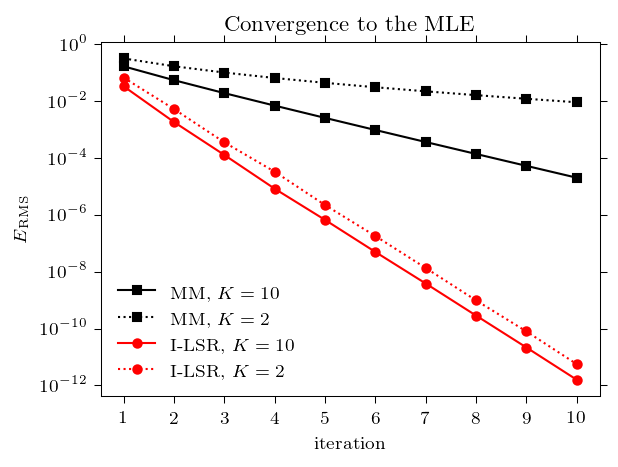

In [8]:
fig, ax = plt.subplots(figsize=(4.25, 3.25))
xs = np.arange(1, n_iters+1)

ax.semilogy(xs, res["MM-rk"], label="MM, $K=10$",
        color="black", marker="s")
ax.semilogy(xs, res["MM-pw"], label="MM, $K=2$",
        color="black", marker="s", ls=":")
ax.semilogy(xs, res["I-LSR-rk"], label="I-LSR, $K=10$",
        color="red", marker="o")
ax.semilogy(xs, res["I-LSR-pw"], label="I-LSR, $K=2$",
        color="red", marker="o", ls=":")

ax.legend()
ax.set_xlabel("iteration")
ax.set_ylabel(r"$E$\textsubscript{RMS}")
ax.set_xticks(xs)
ax.set_yticks([1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12])
ax.set_title("Convergence to the MLE")

fig.savefig("convergence.pdf")